In [39]:
import re, string,os
from glob import glob as gb
import pandas as pd
from tqdm import tqdm
from collections import Counter
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from functions import *
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import strip_tags
from gensim.utils import simple_preprocess
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial
import statistics

plotting.style_('tab20',16)
data_path = "/media/ruben/Elements/ParlaMint/"

In [27]:
# Measuring Distance between Speech Elements using Doc2Vec

def train_doc2vec(language,start_date,end_date):
    data = data_loader.period(language,"lemmatized",start_date=str(start_date),end_date=str(end_date)).dropna().reset_index(drop=True)
    data['date'] = [utils.find_date(x) for x in data['id']]
    data = utils.add_metadata(data,language)
    texts = list(data['text'])
    texts = [simple_preprocess(strip_tags(str(doc)), deacc=True) for doc in texts]
    texts = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
    model = Doc2Vec(documents=texts,
                 vector_size=300,
                 min_count=25, window=12,
                 sample=1e-5,
                 negative=5,
                 hs=1,
                 epochs=75,
                 dm=0,
                 dbow_words=1,
                 workers=12)
    model.save(f"{data_path}/models/doc2vec-{language}-e75.model")
    return data,model

In [28]:
data,m = train_doc2vec('nl',"2018-01-01","2020-12-31")
data.to_csv(f"{data_path}/models/doc2vec-training-data-nl-e75.csv",index=False)

looking for data in  /media/ruben/Elements/ParlaMint/nl/nl-ana-txt/
found 2462 files


In [2]:
m = Doc2Vec.load(f"{data_path}/models/doc2vec-nl-e75.model")

In [49]:
data = data_loader.period(language='nl',data_version='lemmatized',start_date="2019-09",end_date="2020-08")
data = data[data['text'].astype(str).str.len() > 100].reset_index(drop=True)
data = utils.add_metadata(data,'nl')
data['pp'] = utils.preprocess_(data['text'])

found 792 files
/media/ruben/Elements/ParlaMint/nl/nl-ana-txt/ParlaMint-NL_2020-05-07-tweedekamer-3.ana.txt No columns to parse from file
/media/ruben/Elements/ParlaMint/nl/nl-ana-txt/ParlaMint-NL_2020-01-22-tweedekamer-4.ana.txt No columns to parse from file
/media/ruben/Elements/ParlaMint/nl/nl-ana-txt/ParlaMint-NL_2020-05-20-tweedekamer-5.ana.txt No columns to parse from file


In [50]:
data = data.sample(10000).reset_index(drop=True)

In [51]:
data['vec'] = [m.infer_vector(t.split(' ')) for t in tqdm(data['pp'])]

100%|██████████| 10000/10000 [02:39<00:00, 62.89it/s]


In [52]:
data['session'] = ["-".join(x.split('-')[:-1]) for x in data['id']]

In [73]:
d = []
for session in set(data['session']):
    t = data[data['session'] == session].reset_index(drop=True)
    if len(t) < 25:
        continue
    mtrx = pd.DataFrame()

    for c,i in enumerate(t['vec']):
        l = []
        for c1,i1 in enumerate(t['vec']):
            l.append(1 - spatial.distance.cosine(i,i1))
        mtrx[t['id'][c]] = l
    vls = []

    for c in mtrx.columns:

        for v in mtrx[c]:
            vls.append(v)
    d.append([session,statistics.stdev(vls)])

In [74]:
d = pd.DataFrame(d,columns=['s','std'])
d['m'] = [x.split('_')[1][:10] for x in d['s']]
d = d.sort_values('m').reset_index(drop=True)

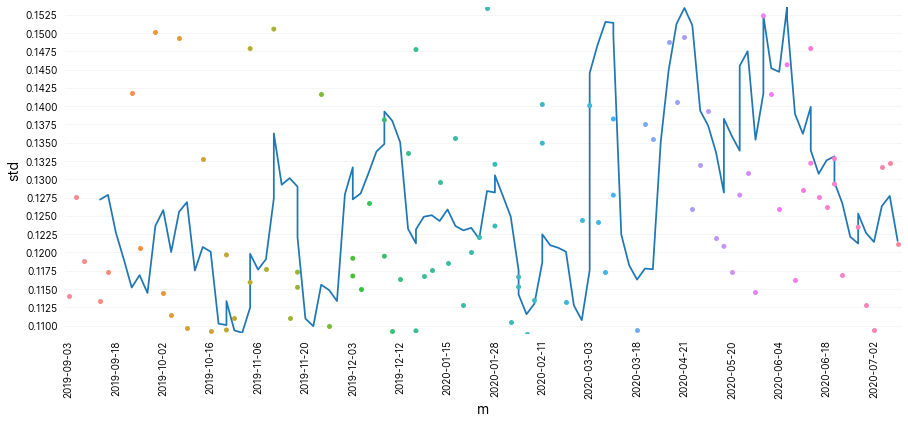

In [83]:
fig,ax = plt.subplots(figsize=(15,6))
sns.stripplot(data=d,x='m',y='std')
plt.plot(d['m'],d['std'].rolling(5,win_type='gaussian').mean(std=5))
plt.locator_params(nbins=20)
for label in ax.get_xticklabels():
    label.set_rotation(90) 